## ReCurrent Neural Network (RNN) Example1
This example is from the Udemy course titled "Deep Learning A-Z - Handson ANNs" by Kirill Eremenko.

In [1]:
# In this example, we will try to predict the stock price for Google for the next 1 month (Jan 2017),
# given stock price data for the last 5 years (Jan 2012 to Dec 2016).
# We wil build an LSTM that predicts the upward and downward trends in Google stock price.
# Financial data can be downloaded from https://finance.yahoo.com/ 

In [2]:
# Part 1 - Data Preprocessing

# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
# Importing the training set
dataset_train = pd.read_csv('../rnn_example1_data/RNN_example1_traindata.csv')
# we are importing only "opening price". But we need to import it as a numpy array of one column. 
# The index [:,1:2] gets only Column1 which is the second column in the file.
# Note that using [:,1] would give us a vector instead of a numpy array.
training_set = dataset_train.iloc[:, 1:2].values

In [4]:
# Feature Scaling
# for RNNs leveraging sigmoid as the activation function, minmax scaling (normalization) is preferred over standardization 
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [5]:
# This data structure determines what RNN will remember.
# Creating a data structure with 60 timesteps and 1 output.
# The RNN will use the last 60 prices to predict the next value. This value is determined by experimentation.
# it is a sliding window of 60 elements, stride is one
# 60 time steps is about 3 months since the data excludes weekends and holidays etc.
# In the training dataset we have 1258 rows. It is actually better NOT to hardcode that value.
X_train = []
y_train = []
for i in range(60, 1258):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
# coverting from list to numpy array
X_train, y_train = np.array(X_train), np.array(y_train)

In [6]:
# Reshaping to the correct dimensions that RNN algorithm expects
# we are adding a new dimension to the numpy array
# for correct syntax, check https://keras.io/layers/recurrent/ 
# 3D tensor with shape (batch_size, timesteps, input_dim)
# batch_size = 1258, timesteps = 60, input_dim = 1 (we have only the opening price)
# we could add additional indicators such as volume, close price etc.
# the stock price could be correlated to volume, closing price, another company's stock price etc. 
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [7]:
# Part 2 - Building the RNN

# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

Using TensorFlow backend.


In [8]:
# Initialising the RNN
# this is a regression problem
regressor = Sequential()

In [9]:
# Adding the first LSTM layer and some Dropout regularisation to prevent overfitting
# for the input_shape, you need to specify only the last 2 arguments which are timesteps, input_dim
# 50 neurons is just a guess.
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
# dropout rate is 20%
regressor.add(Dropout(0.2))

In [10]:
# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

In [11]:
# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

In [12]:
# Adding a fourth LSTM layer and some Dropout regularisation
# since this is the last LSTM layer, we accept the default value of 'false' for 'return_sequences'
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

In [13]:
# Adding the output layer (fully connected layer)
# we are predicting one real value (opening stock price at time t+1), so units=1
regressor.add(Dense(units = 1))

In [14]:
# Compiling the RNN
# actually, according to https://keras.io/optimizers/,  RMSProp is the recommended optimizer for RNNs.
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [15]:
# Fitting the RNN to the training set
# epochs and batch_size are determined by trial and error
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)


Epoch 1/100
1198/1198 [==============================] - 44s 37ms/step - loss: 0.0532
Epoch 2/100
1198/1198 [==============================] - 52s 43ms/step - loss: 0.0075
Epoch 3/100
1198/1198 [==============================] - 36s 30ms/step - loss: 0.0057
Epoch 4/100
1198/1198 [==============================] - 40s 34ms/step - loss: 0.0054
Epoch 5/100
1198/1198 [==============================] - 57s 47ms/step - loss: 0.0058
Epoch 6/100
1198/1198 [==============================] - 83s 69ms/step - loss: 0.0050
Epoch 7/100
1198/1198 [==============================] - 45s 37ms/step - loss: 0.0045
Epoch 8/100
1198/1198 [==============================] - 35s 29ms/step - loss: 0.0046
Epoch 9/100
1198/1198 [==============================] - 42s 35ms/step - loss: 0.0044
Epoch 10/100
1198/1198 [==============================] - 46s 39ms/step - loss: 0.0047
Epoch 11/100
1198/1198 [==============================] - 67s 56ms/step - loss: 0.0042
Epoch 12/100
1198/1198 [===========================

In [16]:
# recall that, if the loss is too little, it indicates overfitting

In [17]:
# Part 3 - Making the predictions and visualising the results

In [18]:
# Getting the real stock price of 2017
# since there are 20 financial dates in a month, the test dataset has 20 values
dataset_test = pd.read_csv('../rnn_example1_data/RNN_example1_testdata.csv')
# The index [:,1:2] gets only Column1 which is the second column in the file.
# Note that using [:,1] would give us a vector instead of a numpy array.
real_stock_price = dataset_test.iloc[:, 1:2].values

In [19]:
# Getting the predicted stock price of 2017.
# since every financial day's stock price depends on the last 60 days, 
# some of the data will include Jan dates which is are the test dataset
# therefore we are concatenating the training and test datasets.
# Also, we do not want to scale the actual test dataset. We will concat the original, unscaled training dataset.
# we are concatting rows (axis=0)
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)


# the inputs array will contain all stock prices we need to predict for Jan 2017
# (starting the first financial date of Jan 2017 to last financial date of Jan 2017)
# at each financial day of Jan 2017, we need the opening prices from the 60 previous financial days
# the inputs array starts with the first financial date of Jan 2017, which is calculated as follows:
# len(dataset_total) - len(dataset_test)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values

# getting the right numpy shape
inputs = inputs.reshape(-1,1)

# now we can scale it (note that it is already fitted, we do not use fit() but transform())
inputs = sc.transform(inputs)

# now we will resize it to 3D that the RNN expects (like we did before)
# 60 time steps is about 3 months since the data excludes weekends and holidays etc.
# In the test dataset we have 80 rows (20 financial days for Jan 2017 and 60 prior values). 
# It is actually better NOT to hardcode that value.
X_test = []
for i in range(60, 80):
    X_test.append(inputs[i-60:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

predicted_stock_price = regressor.predict(X_test)

# we need the unscaled stock prices
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

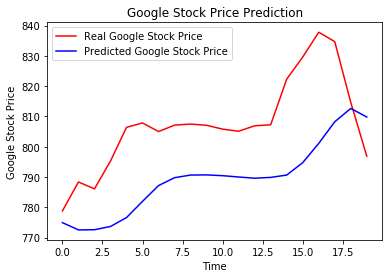

In [20]:
# Visualising the results
# Time is in financial days (0-20)
plt.plot(real_stock_price, color = 'red', label = 'Real Google Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()

In [21]:
# the model lags behind the sudden changes in the actual price by 2-3 days
# the model can be improved by getting more training data, increasing number of time steps, adding additional indicators,
# adding more layers to LSTM, adding more neurons per layer etc.

In [ ]:
# we could also add parameter tuning to this example.
# use scoring = 'neg_mean_squared_error'  in the GridSearchCV class.